In [1]:
import gpytorch
import numpy as np
import pandas as pd
import torch

from bo_functions import ExactGPModel
from bo_functions import train_GP_model
from bo_functions import calc_ei_total

from bo_plotters import plotter_adv
from bo_plotters import y_plotter_adv
from bo_plotters import stdev_plotter_adv
from bo_plotters import error_plotter_adv
from bo_plotters import ei_plotter_adv

In [2]:
#Pull x and Y data from CSV
#Pull x data from CSV
exp_data_doc = "exp_data.csv"
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]

n = len(Xexp)
# print(n)
Theta_True = np.array([1,-1])

In [3]:
#Create training and test data
train_data_doc = "train_3_in_data.csv"
train_data = np.array(pd.read_csv(train_data_doc, header=0,sep=","))
# print(train_data)
train_theta = train_data[:,1:3]
train_p = torch.tensor(train_data[:,1:4])
train_y = torch.tensor(train_data[:,4])
# print(train_p)
# print(train_y)

In [4]:
# initialize likelihood and model
##Assumes a homoskedastic noise model p(y | f) = f + noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# We will use the simplest form of GP model, exact inference
#Defines our model in terms of the class parameters in bo_functions
model = ExactGPModel(train_p, train_y, likelihood)

In [5]:
#Set number of training iterations and train GP
iterations = 500
train_GP_model(model,likelihood, train_p, train_y, iterations, verbose=True)

In [6]:
# Get into evaluation (predictive posterior) mode
#Puts model in evaluation mode
model.eval()
#Puts likelihood in evaluation mode
likelihood.eval();

In [7]:
#Create Meshgrid
p = 10
Theta1 = np.linspace(-2,2,p)
Theta2 = np.linspace(-2,2,p)

theta_mesh = np.array(np.meshgrid(Theta1,Theta2))
theta_space = torch.tensor(theta_mesh.T.reshape(-1,2))

In [8]:
theta1_mesh = theta_mesh[0]
theta2_mesh = theta_mesh[1]

# for i in range(p):
#     for j in range(p):
#         print([theta1_mesh[i,j],theta2_mesh[i,j]])

In [14]:
#Will compare the rigorous solution and approximation later (multidimensional integral over each experiment using a sparse grid)

#Calculate EI
EI = calc_ei_total(p,n,Xexp,Yexp, theta_mesh, model, likelihood)[0]
Error =calc_ei_total(p,n,Xexp,Yexp, theta_mesh, model, likelihood)[1]

#Find Optimal Point (How should I actually be doing this?)
argmin = np.array(np.where(Error == np.amin(Error)))
Theta_1_Opt = float(theta1_mesh[argmin[0],argmin[1]])
Theta_2_Opt = float(theta2_mesh[argmin[0],argmin[1]])
Theta_GP_Opt = np.array((Theta_1_Opt,Theta_2_Opt))
print("The GP estimates \nTheta1, Theta2 = \n")
print(Theta_GP_Opt)

#Find point w/ best EI
argmax = np.array(np.where(EI == np.amax(EI)))
Theta_1_Best = float(theta1_mesh[argmax[0],argmax[1]])
Theta_2_Best = float(theta2_mesh[argmax[0],argmax[1]])
Theta_Best = np.array((Theta_1_Best,Theta_2_Best))
print("The GP estimates the highest EI is at \nTheta1, Theta2 = \n ")
print(Theta_Best)

The GP estimates 
Theta1, Theta2 = 

[0.66666667 0.22222222]
The GP estimates the highest EI is at 
Theta1, Theta2 = 
 
[ 2. -2.]


## Analysis of Expected Improvement
 - Expected Improvement is largest in corners
  - This is rational because you can't explore any further than the edges

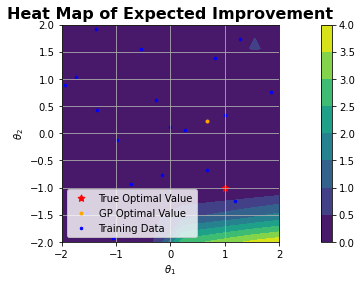

In [10]:
ei_plotter_adv(theta_mesh, EI, Theta_True, Theta_GP_Opt,train_theta,plot_train=True)

#SHould I even plot y, stdev, and error? If so, would I plot them in 3D?

## Analysis of Standard Deviation
 - The GP estimates that the standard deviation is lowest at points that were directly tested
  - This can be rationalized by the way that the contour plot is drawn
 - Standard deviation is smallest away from the edges and larger towards them
  - This is rationalized by the fact that there are less neighbors that the GP is tested and trained with at the boundaries
 - The more points that get tested, the more the standard deviations will decrease

## Analysis of Error Magnitude
 - The GP emulator is most inaccurate when all values of $\bar{p}$ are at their maximum. 
  - In general, the GP is less accurate at extreme points, this is rationalized by the fact that there are less neighbors that the GP is tested and trained with at the boundaries
 - The GP emulator is most accurate when x is at it's maximum, but $\bar{\Theta}= 0$
  - This is rationalized by the fact that multiple terms become zero if any of the values of $\bar{p}$ are zero 
 - GP error is mostly very high, as more iterations are added, these will decrease

## Analysis of GP Emulator (Model y)
 - The GP emulator correctly captures that y increases as $\bar{p}$ increases. This tells us that this GP emulator model could be viable
  - The GP emulator correctly estimates where the lowest y is achieved, but not the actual value of y
  - The GP emulator slightly mistakes where the most positive value of y is, and does not predict the actual value of y
 - The model as it is is inaccurate, BO should increase the accuracy of the emulator